# Smart Grocery Price Prediction Documentation

This documentation provides an overview of the Smart Grocery Price Prediction code. The code uses machine learning techniques to predict grocery prices based on various features, such as market location, category, commodity, and geographical coordinates. It also provides recommendations for the nearest market locations with the lowest prices.

## Prerequisites

To run the code successfully, you need to have the following dependencies installed:

- pandas
- tensorflow
- numpy
- matplotlib
- geopy

After you installed the dependencies, now import the package:

In [7]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
from tensorflow import keras

## Code Overview

The code is divided into several sections:

1. **Data Loading and Preprocessing**: In this section, the dataset is loaded from a CSV file and preprocessed. Missing values are dropped, latitude and longitude columns are formatted and converted to float, and scaling is applied to the numeric features.

In [8]:
# Load the dataset into a DataFrame
dataset = pd.read_csv('Data_Harga1.csv', delimiter=';')

# Drop rows with missing values
dataset = dataset.dropna()

# Preprocess latitude and longitude columns
dataset['latitude'] = dataset['latitude'].str.replace('.', '').str.replace('..', '.')
dataset['longitude'] = dataset['longitude'].str.replace('.', '').str.replace('..', '.')

# Convert latitude and longitude columns to float
dataset['latitude'] = dataset['latitude'].astype(float)
dataset['longitude'] = dataset['longitude'].astype(float)

# Apply the formatting to latitude and longitude columns
dataset['latitude'] = dataset['latitude'] / 1000000
dataset['longitude'] = dataset['longitude'] / 1000000

print(dataset.head)
print(dataset.columns)

<bound method NDFrame.head of              provinsi     kabupaten                pasar  latitude  longitude   
0                ACEH    ACEH BARAT         Pasar Lapang  4.173922  96.141854  \
1                ACEH    ACEH BARAT         Pasar Lapang  4.173922  96.141854   
2                ACEH    ACEH BARAT         Pasar Lapang  4.173922  96.141854   
3                ACEH    ACEH BARAT         Pasar Lapang  4.173922  96.141854   
4                ACEH    ACEH BARAT         Pasar Lapang  4.173922  96.141854   
...               ...           ...                  ...       ...        ...   
53557  SUMATERA UTARA  KOTA SIBOLGA  Pasar Nauli Sibolga  1.738378   9.878446   
53558  SUMATERA UTARA  KOTA SIBOLGA  Pasar Nauli Sibolga  1.738378   9.878446   
53559  SUMATERA UTARA  KOTA SIBOLGA  Pasar Nauli Sibolga  1.738378   9.878446   
53560  SUMATERA UTARA  KOTA SIBOLGA  Pasar Nauli Sibolga  1.738378   9.878446   
53561  SUMATERA UTARA  KOTA SIBOLGA  Pasar Nauli Sibolga  1.738378   9.878446  

2. **Data Preparation**: The dataset is split into features (X) and the target variable (y). Text data is tokenized and padded using the Tokenizer and pad_sequences functions from Keras. The combined features are scaled using StandardScaler.

In [9]:
# Select the relevant columns for features and target variable
features = ['pasar', 'category', 'commodity', 'unit', 'latitude', 'longitude']
target = 'price'

In [10]:
# Extract the features and target variable
X = dataset[features]
y = dataset[target]

In [11]:
# Perform label encoding on the categorical features
label_encoder = LabelEncoder()
for feature in ['pasar', 'category', 'commodity', 'unit']:
    X[feature] = label_encoder.fit_transform(X[feature])

C:\Users\Wilbert\AppData\Local\Temp\ipykernel_14260\432410839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
C:\Users\Wilbert\AppData\Local\Temp\ipykernel_14260\432410839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
C:\Users\Wilbert\AppData\Local\Temp\ipykernel_14260\432410839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
# Convert text data to token sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X['pasar'].astype(str))  # Convert values to strings
X_pasar = tokenizer.texts_to_sequences(X['pasar'].astype(str))
X_pasar = pad_sequences(X_pasar)

In [13]:
# Perform data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Combine the processed data
X_combined = np.concatenate((X_scaled, X_pasar), axis=1)

# Shuffle and split the data
X_combined_train, X_combined_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42)

# Separate the combined data into text and numeric inputs
X_pasar_train = X_combined_train[:, -X_pasar.shape[1]:]
X_train_train = X_combined_train[:, :-X_pasar.shape[1]]
X_pasar_test = X_combined_test[:, -X_pasar.shape[1]:]
X_train_test = X_combined_test[:, :-X_pasar.shape[1]]

# Print the shapes of the data splits
print("X_train_train shape:", X_train_train.shape)
print("X_train_test shape:", X_train_test.shape)
print("X_pasar_train shape:", X_pasar_train.shape)
print("X_pasar_test shape:", X_pasar_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_train shape: (37493, 6)
X_train_test shape: (16069, 6)
X_pasar_train shape: (37493, 1)
X_pasar_test shape: (16069, 1)
y_train shape: (37493,)
y_test shape: (16069,)


In [15]:
# Calculate the maximum length
max_length = X_pasar.shape[1]

print(max_length)

1


3. **Model Architecture**: The code defines a model architecture using the Keras functional API. The architecture consists of an embedding layer for text input, a reshape layer for numeric input, concatenation of both inputs, an LSTM layer, and a dense output layer for price prediction.

In [16]:
# Define the model architecture
embedding_dim = 100  # Adjust the embedding dimension as needed
vocab_size = len(tokenizer.word_index) + 1

# Text input
text_input = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)

# Numeric input
numeric_input_shape = (X_train_train.shape[1],)
numeric_input = Input(shape=numeric_input_shape)
reshaped_numeric_input = Reshape((1, numeric_input_shape[0]))(numeric_input)

# Concatenate text and numeric inputs
concatenated = concatenate([embedding_layer, reshaped_numeric_input], axis=-1)

# LSTM layer
lstm_layer = LSTM(128)(concatenated)

# Output layer
output = Dense(1, activation='linear')(lstm_layer)

# Create the model
model = Model(inputs=[text_input, numeric_input], outputs=output)


4. **Model Training**: The model is compiled with the mean absolute error loss function and the Adam optimizer. It is then trained on the training data with 500 epochs and a batch size of 32.

In [17]:
# Compile and train the model
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit([X_pasar_train, X_train_train], y_train, epochs=500, batch_size=32, validation_data=([X_pasar_test, X_train_test], y_test))

Epoch 1/500
1172/1172 [==============================] - 10s 6ms/step - loss: 39882.1016 - val_loss: 40392.2734
Epoch 2/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39755.8047 - val_loss: 40274.4531
Epoch 3/500
1172/1172 [==============================] - 5s 5ms/step - loss: 39639.1289 - val_loss: 40158.4102
Epoch 4/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39523.3594 - val_loss: 40042.8164
Epoch 5/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39407.7891 - val_loss: 39927.3438
Epoch 6/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39292.3555 - val_loss: 39811.9219
Epoch 7/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39176.9258 - val_loss: 39696.4609
Epoch 8/500
1172/1172 [==============================] - 6s 5ms/step - loss: 39061.4688 - val_loss: 39580.9844
Epoch 9/500
1172/1172 [==============================] - 7s 6ms/step - loss: 38945.9766 - val_loss: 39465.5586


5. **Model Evaluation**: The trained model is evaluated on the test data using the mean absolute error as the evaluation metric.

In [18]:
# Evaluate the model
loss = model.evaluate([X_pasar_test, X_train_test], y_test)

# Print the evaluation result
print("Test Loss:", loss)

503/503 [==============================] - 1s 2ms/step - loss: 22875.4277
Test Loss: 22875.427734375


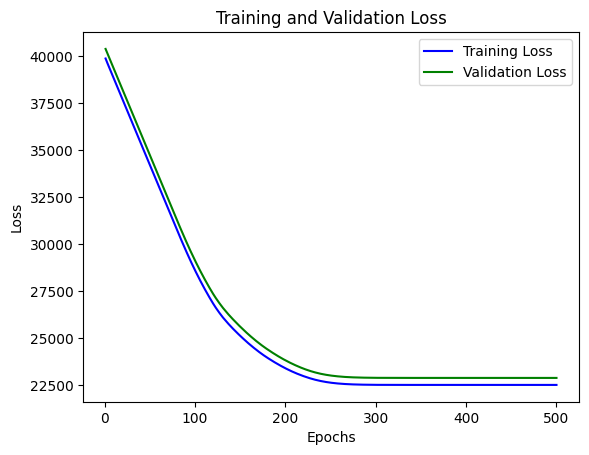

In [19]:
# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6. **User Input and Price Prediction**: User inputs for market location, geographical coordinates, category, and commodity are provided. The inputs are preprocessed, encoded, and combined with numeric features. The model predicts the grocery price based on the user inputs.

In [20]:
provinsi = "JAWA TENGAH"
kabupaten = "KOTA SEMARANG"
latitude = -7.058040
longitude = 110.445680
category = "meat, fish and eggs"
commodity = "Eggs"

In [21]:
# Preprocess user input
user_pasar = tokenizer.texts_to_sequences([kabupaten])  # Tokenize 'pasar'
user_pasar = pad_sequences(user_pasar, maxlen=max_length)  # Pad the sequence

In [22]:
# Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the categorical features
user_provinsi_encoded = onehot_encoder.fit_transform([[provinsi]])
user_category_encoded = onehot_encoder.transform([[category]])
user_commodity_encoded = onehot_encoder.transform([[commodity]])
user_kabupaten_encoded = onehot_encoder.transform([[kabupaten]])

c:\Users\Wilbert\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
# Combine the numeric and categorical features
user_numeric_features = np.array([[latitude, longitude]])  # Reshape to (1, 2)
user_features = np.concatenate((user_numeric_features, user_provinsi_encoded, user_kabupaten_encoded, user_category_encoded, user_commodity_encoded), axis=1)

# Take only the first three elements from user_features
user_features = user_features[:, :6]

# Make predictions
predicted_price = model.predict([user_pasar, user_features])


1/1 [==============================] - 6s 6s/step


In [24]:
# Sort the predicted prices in ascending order
sorted_indices = np.argsort(predicted_price.flatten())
sorted_prices = predicted_price[sorted_indices]

In [25]:
# Get the top five market locations with the lowest predicted prices
recommended_locations = dataset.iloc[sorted_indices[:5]]

In [26]:
# Filter data based on user input
filtered_data = dataset[(dataset['provinsi'] == provinsi) & (dataset['kabupaten'] == kabupaten) & (dataset['category'] == category) & (dataset['commodity'] == commodity)].copy()
print("Filtered Data Length:", len(filtered_data))  # Add this line to check the length of filtered_data

Filtered Data Length: 14


In [27]:
# Create a new DataFrame to store recommended locations with distances
recommended_locations = pd.DataFrame(columns=['pasar', 'price', 'latitude', 'longitude', 'distance'])

# Create a set to store the visited markets
visited_markets = set()

# Calculate distances and add rows to the recommended_locations DataFrame
for i, row in filtered_data.iterrows():
    market = row['pasar']
    if market not in visited_markets:
        distance = geodesic((latitude, longitude), (row['latitude'], row['longitude'])).km
        recommended_locations.loc[i] = [market, row['price'], row['latitude'], row['longitude'], distance]
        visited_markets.add(market)

        # Break the loop if 5 unique markets have been added
        if len(recommended_locations) == 5:
            break

# Sort the recommendations by price and distance
sorted_recommendations = recommended_locations.sort_values(['price', 'distance'])

7. **Market Location Recommendations**: Based on the user inputs, the code filters the dataset to find matching market locations. It calculates the distances between the user's location and each market location using the geodesic function from the geopy library. The code recommends the top five market locations with the lowest prices and closest distances.

In [28]:
# Print the recommendations
print("User input: ")
print(provinsi)
print(kabupaten)
print(latitude) 
print(longitude)
print(category)
print(commodity)
print()

print("Top 5 Recommended Market Locations:")
for i, row in sorted_recommendations.head(5).iterrows():
    print(f"Market: {row['pasar']}")
    print(f"Price: {row['price']}")
    print(f"Distance: {row['distance']} km")
    print()

User input: 
JAWA TENGAH
KOTA SEMARANG
-7.05804
110.44568
meat, fish and eggs
Eggs

Top 5 Recommended Market Locations:
Market: Pasar Johar
Price: 19944.44
Distance: 8.713057235562655 km

Market: Pasar Peterongan
Price: 20888.89
Distance: 6.235409379814343 km



8. **Save The Model**: Save the model using h5 and pickle format. The model will saved as "Store_Recommendation.h5" and "model.pickle"


In [29]:
model.save('Store_Recommendation.h5')

In [30]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
f.close()

## Usage

To run the code, follow these steps:

1. Install the necessary dependencies mentioned in the Prerequisites section.

2. Make sure you have the 'Data_Harga1.csv' dataset in the same directory as the code file.

3. Run the code file using a Python interpreter.

4. The code will prompt for user inputs such as the province, district, latitude, longitude, category, and commodity. Provide the required information and press Enter.

5. The code will display the predicted grocery price based on the user inputs.

6. It will also show the top five recommended market locations based on price and distance.

## Conclusion

The Smart Grocery Price Prediction code demonstrates the use of machine learning techniques to predict grocery prices and provide recommendations for market locations. It utilizes text and numeric inputs, employs an LSTM-based model architecture, and incorporates geographic distance calculations. By running this code, users can predict grocery prices and find nearby market locations with the best prices.